# Image classification using Keras VGG16 trained model (Transfer Learning)

In this notebook, I am using keras Vgg16 model and appending a fully connected layer to vgg16 model and just training fully connected layer for classification.

Steps followed are:

1. Creatd a csv file using the text file from Flickr. This csv will have image_name, Logo_Name, Subset_class, x1,y1,x2,y2 co-ordinates of the images
2. Using label encoder, added another column which contains numeric label for each logo
3. Using the co-ordinates from the csv file, parsing the image using openCV
4. Resize the parsed image and save the image to the drive
5. Creating a new data frame which will have the file path, label other required information of the new image
6. Using ImageDataGenerator from keras, Augumenting image by
    i.   Rotating the image by 60 degrees
    ii.  Changing the brightness of the image
    iii. Flipping the image vertically and horizonatlly
7. Created train, validation and test datasets and also respective ImageDataGenerators for each set
8. Create object of Vgg16 trained model from keras and connected a fully connected network at the end of this vgg16 model
9. Update the property of Vgg16 model so that it is not trained when training the classifier
10. Define a check point which will save best weights, these weights are used to load the best model from training epochs
11. Start training the model with defined number of epochs 
12. Here i am not using a custom optimizer. We can also use optimizer with our own hyper parameters but I am just making use 
    of Adam optimizer with default hyper parameters. If the accuracy of the model is not good, switch to optimizer with your       set of hyper parameters
13. Plotting the train and validation loss which gives us a good understing of how model is fitting
14. Load the best weights from training and compile the model. Save the model for future use
15. Showing the accuracy of the model with test data

### Loading the required libraries

In [1]:
import numpy as np
import pandas as pd
import os
import cv2
#from itertools import product
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
#from scipy import ndimage
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential, load_model
from keras.layers import Conv2D, MaxPooling2D, Activation, Dropout, Flatten, Dense, Input
from keras import applications, optimizers
from keras.applications import VGG16
from keras.applications.vgg16 import preprocess_input
from keras.callbacks import ModelCheckpoint

Using TensorFlow backend.


### Loading the csv using pandas

In [2]:
# Converted the txt file from flicker to a csv 
image_data = pd.read_csv("Image_Labels.csv")
image_data.head()

,Image_Name,Logo_Name,Subset_Class,X1,Y1,X2,Y2
0,144503924.jpg,Adidas,1,38,12,234,142
1,2451569770.jpg,Adidas,1,242,208,413,331
2,390321909.jpg,Adidas,1,13,5,89,60
3,4761260517.jpg,Adidas,1,43,122,358,354
4,4763210295.jpg,Adidas,1,83,63,130,93


### Using encoder to create numeric labels

In [3]:
label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(image_data.Logo_Name)
image_data["Labels"] = encoded_labels

### Declaring the required variables

In [4]:
image_path = './flickr_logos_27_dataset_images'
image_width = 32
image_height = 32
data_dir = './Augmented_images'
image_ext = ".jpg"
if not os.path.exists(data_dir):
        os.makedirs(data_dir)

### Creating a new dataframe by looping through each file from the training set. 
     Cropping the image using the given co-ordinates
     Resizing the image to 32 X 32
     Saving the image to local drive

In [5]:
augmented_image_df = pd.DataFrame(columns=["Image_File_Path","Label", "Subset_label", "Brand_Name"])
for index, row in image_data.iterrows():
    file_path = os.path.join(image_path, row["Image_Name"])
    label =row["Labels"] 
    subset_class =row["Subset_Class"]
    brand_name = row["Logo_Name"]
    #print(file_path)
    image = cv2.imread(file_path)
    y1,y2,x1,x2 = int(row["Y1"]),int(row["Y2"]),int(row["X1"]),int(row["X2"])
    crop_img = image[y1:y2, x1:x2]
    # Shafi : For few images, co ordinates are not proper. For example 2662264721.jpg has co-ordinates
    #         as 3,197,3,197 which would result in a image of size zero or an empty image            
    if crop_img.size > 0:
        resized_img = cv2.resize(crop_img, (image_width,image_height))
        new_file_name = str(index)+"_"+brand_name+"_"+str(subset_class)+"_"+str(label)+image_ext
        newfile_path = os.path.join(data_dir,new_file_name)
        augmented_image_df.loc[len(augmented_image_df)] = [newfile_path,label, subset_class,brand_name]
        cv2.imwrite(newfile_path,resized_img)



### Performing custom image augmentation on the cropped logo dataset by using ImageDataGenerator

1. Rotating the image
2. Flipping the image
3. Changing brightness of the image
4. Also required image pre-processing

In [6]:
# As the data set is already cropped, i am not using vertical and horizontal shift
# genrating new set of data by rotating, flipping and changing the brightness of the image
datagen = ImageDataGenerator(   featurewise_center=True,
                                featurewise_std_normalization=True,
                                rotation_range=60,
                                brightness_range=[0.3,0.7],
                                horizontal_flip=True,
                                vertical_flip = True)

valgen = ImageDataGenerator(   featurewise_center=True,
                                featurewise_std_normalization=True,
                                rotation_range=60,
                                brightness_range=[0.3,0.7],
                                horizontal_flip=True,
                                vertical_flip = True)
batch_size = 20

### Creating train, test and validation data sets

In [7]:
train_data_frame, test_data_frame = train_test_split(augmented_image_df, test_size=0.2)
train_df, validation_df = train_test_split(train_data_frame, test_size=0.2)

### Creating ImageDataGenerators for train and validation

In [8]:
train_generator = datagen.flow_from_dataframe(train_data_frame,x_col = 'Image_File_Path',
y_col = 'Brand_Name',
directory = None,
target_size=(image_width, image_height),
batch_size=batch_size,
class_mode='sparse')


validation_generator = valgen.flow_from_dataframe(validation_df,x_col = 'Image_File_Path',
y_col = 'Brand_Name',
directory = None,
target_size=(image_width, image_height),
batch_size=batch_size,
class_mode='sparse')

Found 3624 images belonging to 27 classes.
Found 725 images belonging to 27 classes.


### Creating object of VGG16 from keras

In [9]:
base_model = VGG16(weights="imagenet", include_top=False, input_shape=(image_width, image_height, 3))
base_model.summary()

Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 32, 32, 3)         0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 32, 32, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 32, 32, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 16, 16, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 16, 16, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 16, 16, 128)       147584    
_________________________________________________________________
bloc

### Freezing early layers of VGG16 model

In [10]:
base_model.trainable = False

### Creating a sequntial model and adding VGG16 as the first layer and also adding other dense alyers

In [11]:
model_tl = Sequential()
model_tl.add(base_model)
model_tl.add(Flatten())

model_tl.add(Dense(256, activation="relu"))
model_tl.add(Dropout(0.5))
model_tl.add(Dense(128, activation="relu"))

model_tl.add(Dense(27, activation="softmax"))
model_tl.summary()
checkpoint_name = './Transfer_learning_weights.hdf5'

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 1, 1, 512)         14714688  
_________________________________________________________________
flatten_1 (Flatten)          (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               131328    
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 128)               32896     
_________________________________________________________________
dense_3 (Dense)              (None, 27)                3483      
Total params: 14,882,395
Tr

### Creating a check point to save the best weights

In [12]:
#compiling
model_tl.compile(loss='sparse_categorical_crossentropy',optimizer="adam", metrics=['accuracy'])
checkpoint = ModelCheckpoint(checkpoint_name, monitor='val_acc', verbose=0, save_best_only=True, mode='auto',
                                 save_weights_only=True)
callbacks_list = [checkpoint]

### Training the model with 25 epochs

In [13]:
model_tl.fit_generator(
        train_generator,
        steps_per_epoch=len(train_df)//batch_size,
        epochs=25,
        validation_data=validation_generator,
        validation_steps=len(validation_df)//batch_size, callbacks=callbacks_list)

Instructions for updating:
Use tf.cast instead.
Epoch 1/25


c:\python37_64bit\lib\site-packages\keras_preprocessing\image\image_data_generator.py:699: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
c:\python37_64bit\lib\site-packages\keras_preprocessing\image\image_data_generator.py:707: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


144/144 [==============================] - 20s 141ms/step - loss: 6.3898 - acc: 0.2951 - val_loss: 1.2412 - val_acc: 0.6792
Epoch 2/25
144/144 [==============================] - 20s 138ms/step - loss: 1.9302 - acc: 0.5733 - val_loss: 0.7406 - val_acc: 0.8000
Epoch 3/25
144/144 [==============================] - 20s 139ms/step - loss: 1.3495 - acc: 0.6701 - val_loss: 0.5448 - val_acc: 0.8468
Epoch 4/25
144/144 [==============================] - 20s 138ms/step - loss: 1.0810 - acc: 0.7174 - val_loss: 0.4264 - val_acc: 0.8794
Epoch 5/25
144/144 [==============================] - 20s 141ms/step - loss: 0.9281 - acc: 0.7566 - val_loss: 0.3192 - val_acc: 0.9149
Epoch 6/25
144/144 [==============================] - 21s 147ms/step - loss: 0.7741 - acc: 0.7913 - val_loss: 0.2778 - val_acc: 0.9277
Epoch 7/25
144/144 [==============================] - 21s 143ms/step - loss: 0.6870 - acc: 0.8167 - val_loss: 0.3111 - val_acc: 0.9121
Epoch 8/25
144/144 [==============================] - 21s 145ms/st

### Plotting Trainning and validation loss

Training and Validation loss


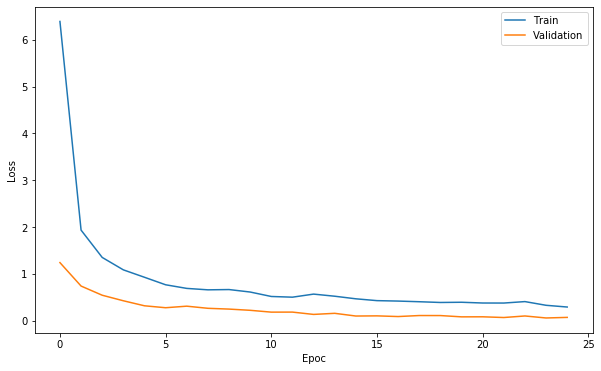

In [20]:
import matplotlib.pyplot as plt
train_loss = model_tl.history.history['loss']
valid_loss = model_tl.history.history['val_loss']
epochs = len(train_loss)
print("Training and Validation loss")
x_axis = range(0, epochs)
plt.figure(figsize = (10,6))
plt.plot(x_axis, train_loss, label='Train')
plt.plot(x_axis, valid_loss, label='Validation')
plt.legend()
plt.xlabel("Epoc")
plt.ylabel("Loss")
plt.show()

### loading the best weights from the training and compiling the model

In [14]:
model_tl.load_weights('Transfer_learning_weights.hdf5')
model_tl.compile(loss='sparse_categorical_crossentropy',optimizer="adam", metrics=['accuracy'])

In [15]:
model_tl.save("Transfer_learning_model.h5")

### Creating test ImageDataGenerator

In [21]:
testgen = ImageDataGenerator(   featurewise_center=True,
                                featurewise_std_normalization=True,
                                rotation_range=30,
                                brightness_range=[0.25,0.75],
                                horizontal_flip=True,
                                vertical_flip = True)


test_generator = testgen.flow_from_dataframe(test_data_frame,x_col = 'Image_File_Path',
y_col = 'Brand_Name',
directory = None,
target_size=(image_width, image_height),
batch_size=batch_size,
class_mode='sparse')

Found 907 images belonging to 27 classes.


### Validating the model with test data and printing the accuracy

In [22]:
nb_samples = len(test_data_frame)

test_score = model_tl.evaluate_generator(test_generator,steps = nb_samples/batch_size)

print("Test accuracy is : ", test_score[1]*100, "%")
    

c:\python37_64bit\lib\site-packages\keras_preprocessing\image\image_data_generator.py:699: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
c:\python37_64bit\lib\site-packages\keras_preprocessing\image\image_data_generator.py:707: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


Test accuracy is :  94.81808087791602 %
